# UCLA Master in Quantitative Economics 
## Replication File for <i>Re-Estimating the Effect of Skill Specificity on Immigration Attitudes: A Double Machine Learning Approach<i>
### Author: Nathan Kim 
### Faculty Advisor: Denis Chetverikov

In [1]:
# Standard modules 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
# Utilities 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures 

In [3]:
# Linear, tree-based, and ensemble models 
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [4]:
# dmlc XGBoost 
import xgboost as xgb

In [5]:
# DMLDiD 
from DMLDiD import DMLDiD, DMLDiD_TF

In [6]:
# LASSO l1 selection rule 
from bcch_rule import bcch_rule

# Data import & cleaning 

In [7]:
# Import data
df = pd.read_stata('gsp_data_final.dta')

In [8]:
# Subsetting data 
df = df[['syear', 'pid', 'concern_rec', 'treated', 'unemployed2', 'income', 'age', 'educyears', 'skillsp', 'our', 
         'tenure2', 'transition', 'percentimmigr', 'manualwork', 'gender', 'temporary', 'dv', 'churchatt', 'pgsbil']]

In [9]:
# Sort by surveyee ID and survey year 
df = df.sort_values(by=['pid', 'syear'])

In [10]:
df.head()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,tenure2,transition,percentimmigr,manualwork,gender,temporary,dv,churchatt,pgsbil
0,1999,201,2.0,0.0,0.0,NaN,73.0,11.0,NaN,NaN,10.770837,NaN,6.917376,0.0,2.0,0.0,0.0,2.0,1
1,2000,201,2.0,0.0,0.0,NaN,74.0,10.5,NaN,NaN,3.410256,NaN,82.347237,0.0,2.0,0.0,0.0,2.0,1
2,2001,201,NaN,0.0,0.0,NaN,75.0,10.5,NaN,NaN,11.610270,NaN,81.313133,0.0,2.0,0.0,NaN,2.0,1
3,2002,201,1.0,0.0,0.0,NaN,76.0,10.5,NaN,NaN,7.950000,NaN,83.075089,0.0,2.0,0.0,0.0,2.0,1
4,2003,201,2.0,0.0,0.0,NaN,77.0,10.5,NaN,NaN,12.263576,NaN,80.788483,0.0,2.0,0.0,0.0,2.0,1


In [11]:
# Number of observations each year 
df.dropna().groupby(by='syear').size()

syear
2000    11849
2001     1786
2002    11606
2003     1362
2004    10442
2005     1161
2006     1772
2007     9661
2008     1699
2009     9692
2010     1458
2011     9674
dtype: int64

In [12]:
# Dataframe containing only the years 2003, 2004, and 2005 (i.e. treatment period)
time_frame = df.loc[(df['syear'] == 2003) | (df['syear'] == 2004) | (df['syear'] == 2005)]

In [13]:
# Sort by surveyee ID and survey year 
time_frame = time_frame.sort_values(by=['pid', 'syear'])

In [14]:
time_frame.head()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,tenure2,transition,percentimmigr,manualwork,gender,temporary,dv,churchatt,pgsbil
4,2003,201,2.0,0.0,0.0,NaN,77.0,10.5,NaN,NaN,12.263576,NaN,80.788483,0.0,2.0,0.0,0.0,2.0,1
5,2004,201,3.0,0.0,0.0,NaN,78.0,10.5,NaN,NaN,9.666667,NaN,84.533333,0.0,2.0,0.0,1.0,2.0,1
6,2005,201,1.0,0.0,0.0,NaN,79.0,10.5,NaN,NaN,12.523881,NaN,80.142349,0.0,2.0,0.0,0.0,2.0,1
14,2003,203,2.0,0.0,0.0,4.0,43.0,18.0,NaN,NaN,12.263576,NaN,80.788483,0.0,1.0,0.0,0.0,1.0,4
15,2004,203,2.0,1.0,1.0,NaN,44.0,18.0,NaN,NaN,9.666667,NaN,84.533333,0.0,1.0,0.0,0.0,2.0,4


In [15]:
# Find IDs of surveyees that were unemployed (treated) during 2003-2005 
treated_id = list(time_frame.loc[time_frame['unemployed2'] == 1]['pid'].unique())

In [16]:
# Find IDs of surveyees that were employed all throughout 2003-2005 (control)
control_2003 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2003)]['pid'].unique())
control_2004 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2004)]['pid'].unique())
control_2005 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2005)]['pid'].unique())

In [17]:
control_id = list(set(control_2003) & set(control_2004) & set(control_2005))

In [18]:
# All IDs including both treated and control groups
relevant_id = treated_id + control_id

In [19]:
# 1 == male, 2 == female 
# Replace 2 with 0 to create 'male' dummy variable 
df['gender'] = df['gender'].replace(2, 0)

In [20]:
# 1 == yes, 2 == no
# Replace 2 with 0 to create 'church attendance' dummy variable 
df['churchatt'] = df['churchatt'].replace(2, 0)

In [21]:
# Type of schooling 
df['pgsbil'] = df['pgsbil'].replace(-1, np.nan)

In [22]:
stype_dummies = pd.get_dummies(df['pgsbil'])

In [23]:
stype_dummies.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [24]:
stype_dummies = stype_dummies.rename(columns = {1.0 : 'stype1', 2.0 : 'stype2', 3.0 : 'stype3', 4.0 : 'stype4', 
                                      5.0 : 'stype5', 6.0 : 'stype6', 7.0 : 'stype7' })

In [25]:
df = pd.concat([df, stype_dummies], axis=1)

In [26]:
df = df.drop('pgsbil', axis=1)

In [27]:
# Slice dataframe with years 2002 and 2011

# Before treatment = 2002 
# After treatment = 2011

df_2002 = df.loc[df['syear'] == 2002].dropna()
df_2002 = df_2002.loc[df_2002['pid'].isin(relevant_id)]

df_2011 = df.loc[df['syear'] == 2011].dropna()
df_2011 = df_2011.loc[df_2011['pid'].isin(relevant_id)]

In [28]:
# Each year does not have the same number of surveyees/same surveyee IDs  
syear_id = list(df_2002.loc[df_2002['pid'].isin(df_2011['pid'])]['pid'])

In [29]:
df = df.loc[(df['pid'].isin(syear_id)) & ((df['syear'] == 2002) | (df['syear'] == 2011))].reset_index(drop=True)

In [30]:
df['treated'] = 0 
df.loc[df['pid'].isin(treated_id), 'treated'] = 1

In [31]:
df.head()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,...,temporary,dv,churchatt,stype1,stype2,stype3,stype4,stype5,stype6,stype7
0,2002,901,2.0,0,0.0,2.0,51.0,10.5,0.617639,9.205261,...,0.0,0.0,1.0,1,0,0,0,0,0,0
1,2011,901,2.0,0,0.0,3.0,60.0,10.5,0.490324,8.017141,...,0.0,0.0,1.0,1,0,0,0,0,0,0
2,2002,1501,1.0,0,0.0,3.0,44.0,18.0,0.719778,3.658580,...,0.0,0.0,1.0,0,0,0,1,0,0,0
3,2011,1501,1.0,0,0.0,5.0,53.0,18.0,0.708843,2.422332,...,0.0,0.0,1.0,0,0,0,1,0,0,0
4,2002,2301,2.0,0,0.0,5.0,56.0,18.0,0.719778,3.658580,...,0.0,0.0,1.0,0,0,0,1,0,0,0


In [32]:
df.tail()

,syear,pid,concern_rec,treated,unemployed2,income,age,educyears,skillsp,our,...,temporary,dv,churchatt,stype1,stype2,stype3,stype4,stype5,stype6,stype7
8203,2011,8249801,1.0,0,0.0,4.0,55.0,18.0,0.708843,2.422332,...,0.0,0.0,1.0,0,0,0,1,0,0,0
8204,2002,8249802,2.0,0,0.0,4.0,43.0,17.0,0.719778,3.658580,...,0.0,0.0,1.0,0,0,1,0,0,0,0
8205,2011,8249802,1.0,0,0.0,5.0,52.0,18.0,0.708843,2.422332,...,0.0,0.0,1.0,0,0,0,1,0,0,0
8206,2002,8249803,1.0,0,0.0,1.0,21.0,13.0,3.047472,11.855548,...,1.0,0.0,1.0,0,0,0,1,0,0,0
8207,2011,8249803,1.0,0,0.0,2.0,30.0,18.0,0.708843,2.422332,...,1.0,0.0,1.0,0,0,0,1,0,0,0


In [33]:
df.shape

(8208, 25)

# Setting up data for Feature Selection

In [34]:
standard = StandardScaler()
min_max = MinMaxScaler()
poly2 = PolynomialFeatures(degree=2, include_bias=False)

In [35]:
D = np.array(df.loc[df['syear'] == 2002, 'treated'])

In [36]:
X = np.array(df.loc[df['syear'] == 2002, ['income', 'age', 'educyears', 'skillsp', 'our', 'tenure2', 'transition', 
                                          'percentimmigr', 'manualwork', 'gender', 'temporary', 'dv', 'churchatt', 
                                          'stype1', 'stype2', 'stype3','stype4','stype5','stype6','stype7']])

In [37]:
X_s = standard.fit_transform(X[:, 0:8])

In [38]:
X_scaled = np.concatenate((X_s, X[:, 8:]), axis=1)

In [39]:
Y_0 = np.array(df.loc[df['syear'] == 2002, 'concern_rec'])
Y_1 = np.array(df.loc[df['syear'] == 2011, 'concern_rec'])

In [40]:
df = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X), axis=1)

In [41]:
X_mu = df[np.where(df[:, 2] == 0)][:, 3:]

In [42]:
df_scaled = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X_scaled), axis=1)

X_mu_scaled = df_scaled[np.where(df_scaled[:, 2] == 0)][:, 3:]

In [43]:
Y_0_mu = df[np.where(df[:, 2] == 0)][:, 1]
Y_1_mu = df[np.where(df[:, 2] == 0)][:, 0]

# Feature Selection/Importance

## Plot Settings

In [44]:
plt.style.use('ggplot')

In [45]:
plt.rcParams['font.family'] = 'Garamond'
plt.rcParams['font.weight'] = 'bold'
font_style = {'fontname':'Garamond'}

In [46]:
col_names = ['Income', 'Age', 'Educ', 'Task Comp', 'Occ Unemp', 'Tenure', 'Transition',
             'Perc Immigr', 'Manual', 'Gender', 'Temp', 'Diff', 'Church', 'SType1', 
             'SType2', 'SType3','SType4','SType5','SType6','SType7'] 

## Random Forest

In [47]:
p_max = X.shape[1]

params = {'max_depth'    : np.linspace(1, 10, 10, dtype=int),
          'max_features' : np.linspace(1, p_max, int(p_max), dtype=int)}

In [48]:
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=0), 
                     param_grid=params, scoring='neg_log_loss', cv=3).fit(X, D)

In [49]:
rf_cv.best_params_

{'max_depth': 6, 'max_features': 6}

In [50]:
rf = RandomForestClassifier(random_state=0, max_depth=6, max_features=6).fit(X, D)

In [51]:
importance = pd.DataFrame({'importance': rf.feature_importances_ * 100}, index=col_names)
importance = importance.sort_values(by='importance', axis=0, ascending=True)

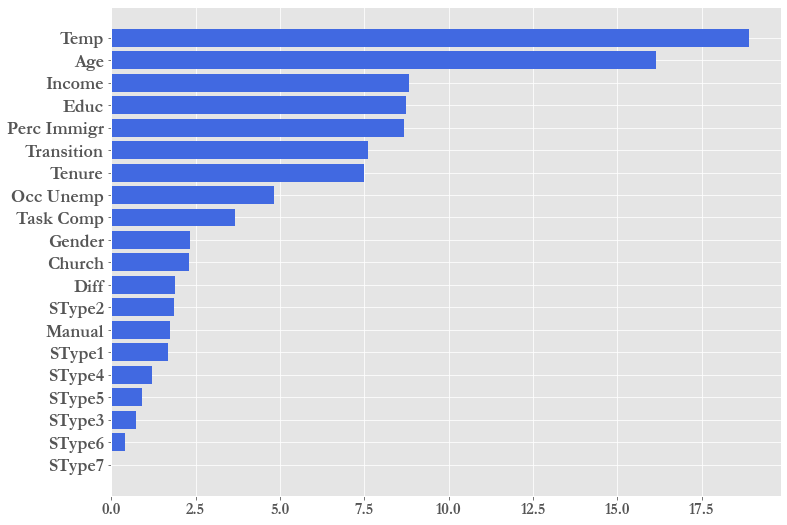

In [52]:
plt.figure(figsize=(12, 9))
bar_plot = plt.barh(importance.index, importance['importance'], color='royalblue')
plt.yticks(fontsize=18, **font_style, fontweight='bold')
plt.xticks(fontsize=16, **font_style, fontweight='bold')
# plt.savefig('rf.png', dpi=500)
plt.show()

## LASSO

In [53]:
params = {'alpha' : np.linspace(0.000001, 1, 10000)}

In [54]:
lasso_cv = GridSearchCV(estimator=Lasso(random_state=0, fit_intercept=False, max_iter=5000), 
                        param_grid=params, cv=3).fit(X_scaled, D)

In [55]:
lasso_cv.best_params_

{'alpha': 0.0024012376237623765}

In [56]:
lasso = Lasso(random_state=0, alpha=0.0024012376237623765, max_iter=5000).fit(X_scaled, D)

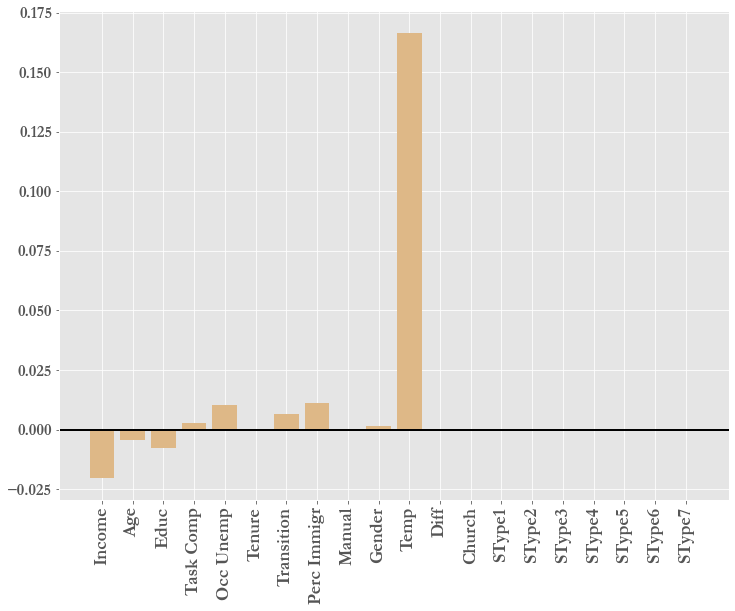

In [57]:
plt.figure(figsize=(12, 9))
plt.bar(col_names, lasso.coef_.tolist(), color='burlywood')
plt.yticks(fontsize=16, **font_style, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=18, **font_style, fontweight='bold')
plt.axhline(y=0, linewidth=2, color='black')
# plt.savefig('lasso.png', dpi=500)
plt.show()

## Combining Figures

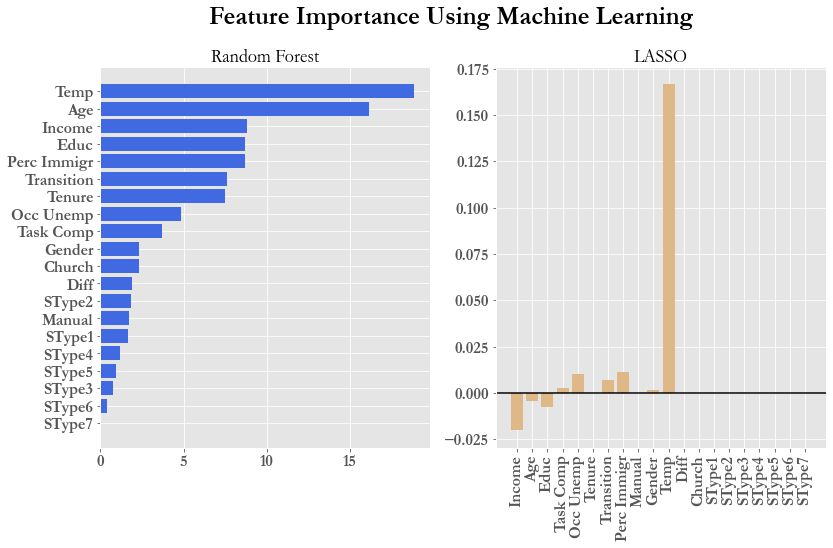

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
fig.suptitle('Feature Importance Using Machine Learning', fontsize=25, fontweight='bold', y=1)
ax[0].set_title('Random Forest', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].barh(importance.index, importance['importance'], color='royalblue')
ax[1].set_title('LASSO', fontsize=18)
ax[1].tick_params(axis='x', which='major', labelrotation=90, labelsize=16)
ax[1].tick_params(axis='y', which='major', labelsize=16)
ax[1].bar(col_names, lasso.coef_.tolist(), color='burlywood')
ax[1].axhline(y=0, color='black')
plt.savefig('features.png', dpi=500, bbox_inches='tight')
plt.show()

# DMLDiD Estimation 

In [59]:
X = X[:, :-1]

In [60]:
X_scaled = X_scaled[:, :-1]

In [61]:
X_mu = X_mu[:, :-1]

In [62]:
X_mu_scaled = X_mu_scaled[:, :-1]

In [63]:
X_p = poly2.fit_transform(X)

In [64]:
X_p_scaled = min_max.fit_transform(X_p)

In [65]:
X_mu_p = poly2.fit_transform(X_mu)

In [66]:
df_p_scaled = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X_p_scaled), axis=1)

In [67]:
X_mu_p_scaled = df_p_scaled[np.where(df_p_scaled[:, 2] == 0)][:, 3:]

## Logit-L1 & LASSO

In [68]:
g_params = {'C' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
g_ML = LogisticRegression(random_state=0, penalty='l1', solver='saga', max_iter=10000)

In [69]:
c, alpha = 1.1, 0.05
hyp = bcch_rule(X_mu_scaled, Y_1_mu - Y_0_mu, c, alpha)

In [70]:
mu_params = {'alpha' : [hyp]}
mu_ML = Lasso(random_state=0, alpha=hyp)

In [71]:
DMLDiD(Y_1, Y_0, D, X_scaled, g_ML, g_params, mu_ML, mu_params)

(-0.0324739141913474, 0.044283887119001886)

In [72]:
c, alpha = 1.1, 0.05
hyp = bcch_rule(X_mu_p_scaled, Y_1_mu - Y_0_mu, c, alpha)

In [73]:
mu_params = {'alpha' : [hyp]}
mu_ML = Lasso(random_state=0, alpha=hyp)

In [74]:
DMLDiD(Y_1, Y_0, D, X_p_scaled, g_ML, g_params, mu_ML, mu_params)

(-0.03916775271938008, 0.04499936696711767)

## Neural Networks 

In [75]:
mspecs = [[3, 2], [2]]
optimizers = ['sgd', 'adam']
lrates = [0.00001, 0.0001, 0.001, 0.01]
regs = [0.01, 0.1, 1]

In [76]:
g_params = [mspecs, optimizers, lrates, regs]
mu_params = [mspecs, optimizers, lrates, regs]

In [77]:
DMLDiD_TF(Y_1, Y_0, D, X_scaled, X_scaled.shape[1], g_params, mu_params)

(-0.018199457451584855, 0.04445515847963718)

In [78]:
DMLDiD_TF(Y_1, Y_0, D, X_p_scaled, X_p_scaled.shape[1], g_params, mu_params)

(-0.045370940714963164, 0.04199449348802667)

## Random Forest 

In [79]:
p_max = X.shape[1]

In [80]:
g_params = {'max_depth'    : np.linspace(1, 10, 10, dtype=int),
            'max_features' : np.linspace(1, p_max, int(p_max), dtype=int)}

g_ML = RandomForestClassifier(random_state=0)

In [81]:
mu_params = {'max_depth'    : np.linspace(1, 10, 10, dtype=int),
             'max_features' : np.linspace(1, p_max, int(p_max), dtype=int)}

mu_ML = RandomForestRegressor(random_state=0)

In [82]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.04307322957792531, 0.04104453599710479)

In [83]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.04394188904588268, 0.0405503761561771)

## Gradient Boosting

In [84]:
g_params = {'max_depth'     : [1, 2, 3], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
            'n_estimators'  : [25, 50, 75, 100, 125],
            'max_features'  : [3, 4, 5, 6, 7, 8]}

g_ML = GradientBoostingClassifier(random_state=0)

In [85]:
mu_params = {'max_depth'     : [1, 2, 3], 
             'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
             'n_estimators'  : [25, 50, 75, 100, 125],
             'max_features'  : [3, 4, 5, 6, 7, 8]}

mu_ML = GradientBoostingRegressor(random_state=0)

In [86]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.044064483206084866, 0.04126290896869196)

In [87]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.040622249128549275, 0.041570910655469535)

## AdaBoost

In [88]:
g_params = {'learning_rate'  : [0.0001, 0.001, 0.01, 0.1, 0.5],
            'n_estimators'   : [25, 50, 75, 100, 125],
            'base_estimator' : [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                                DecisionTreeClassifier(max_depth=3)]}

g_ML = AdaBoostClassifier(random_state=0)

In [89]:
mu_params = {'learning_rate'  : [0.0001, 0.001, 0.01, 0.1, 0.5],
             'n_estimators'   : [25, 50, 75, 100, 125],
             'base_estimator' : [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=2), 
                                 DecisionTreeRegressor(max_depth=3)]}

mu_ML = AdaBoostRegressor(random_state=0)

In [90]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.029582273109815014, 0.041930093252002844)

In [91]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.026613181883137292, 0.0419157445117166)

## XGBoost

In [92]:
g_params = {'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
            'n_estimators'  : [25, 50, 75, 100, 125],
            'reg_lambda'    : [0.1, 0.5, 1],
            'reg_alpha'     : [0.1, 0.5, 1],
            'max_depth'     : [1, 2, 3]}

g_ML = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

In [93]:
mu_params = {'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.5],
             'n_estimators'  : [25, 50, 75, 100, 125],
             'reg_lambda'    : [0.1, 0.5, 1],
             'reg_alpha'     : [0.1, 0.5, 1],
             'max_depth'     : [1, 2, 3]}

mu_ML = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

In [94]:
DMLDiD(Y_1, Y_0, D, X, g_ML, g_params, mu_ML, mu_params)

(-0.04115000166927788, 0.04123762170090014)

In [95]:
DMLDiD(Y_1, Y_0, D, X_p, g_ML, g_params, mu_ML, mu_params)

(-0.03678867605099304, 0.041686205936385466)